Jieyi Yao, Foster Lockerbie

Running time is about 4 minutes( For Mac M1Pro)

## Importing + Data Preprocessing

In [1]:
import glob
import json
import pandas as pd
import spacy
import re
from collections import Counter
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
file_pattern = "DevGPT/snapshot_*/**/*_issue_sharings.json"

file_paths = glob.glob(file_pattern, recursive=True)

combined_dfs = []

# Loop through each file and process
for file_path in file_paths:
    try:
        # Load JSON file
        with open(file_path, 'r') as file:
            data = json.load(file)
        
        # Flatten the JSON structure
        df = pd.json_normalize(
            data["Sources"],
            record_path=["ChatgptSharing"],  # Path to nested data
            meta=["Author"],  # Include top-level metadata
            sep="_"
        )
        
        # Convert date columns to datetime
        df['DateOfConversation'] = pd.to_datetime(df.get('DateOfConversation'), errors='coerce')
        df['DateOfAccess'] = pd.to_datetime(df.get('DateOfAccess'), errors='coerce')
        
        # Handle missing values in 'Title'
        df['Title'] = df['Title'].fillna('Unknown')
        
        # Save individual file results as CSV
        output_file = file_path.replace(".json", ".csv")
        df.to_csv(output_file, index=False)
        print(f"Processed and saved: {output_file}")
        
        # Optionally store the DataFrame for later merging
        combined_dfs.append(df)
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Optional: Combine all DataFrames into one
if combined_dfs:
    combined_data = pd.concat(combined_dfs, ignore_index=True)
    combined_data.to_csv("combined_issue_sharings.csv", index=False)
    print("All files combined and saved as combined_issue_sharings.csv")

Processed and saved: DevGPT/snapshot_20230824/20230824_101836_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230831/20230831_061759_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230727/20230727_195941_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230810/20230810_123938_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230817/20230817_130502_issue_sharings.csv
Processed and saved: DevGPT/snapshot_20230803/20230803_094705_issue_sharings.csv
All files combined and saved as combined_issue_sharings.csv


In [3]:
df = pd.read_csv('combined_issue_sharings.csv')
df['DateOfConversation'] = pd.to_datetime(df['DateOfConversation'], errors='coerce')
df['DateOfAccess'] = pd.to_datetime(df['DateOfAccess'], errors='coerce')
df.fillna({'Title': 'No Title', 'HTMLContent': ''}, inplace=True)
df['TokenEfficiency'] = df['TokensOfAnswers'] / df['TokensOfPrompts']

df.to_csv('cleaned_data.csv', index=False)

In [4]:
df = pd.read_csv('cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        2089 non-null   object 
 1   Status                     2089 non-null   int64  
 2   DateOfConversation         1797 non-null   object 
 3   DateOfAccess               1896 non-null   object 
 4   Title                      2089 non-null   object 
 5   NumberOfPrompts            1896 non-null   float64
 6   TokensOfPrompts            1896 non-null   float64
 7   TokensOfAnswers            1896 non-null   float64
 8   Model                      1632 non-null   object 
 9   Conversations              1896 non-null   object 
 10  HTMLContent                1896 non-null   object 
 11  Mention_MentionedURL       2089 non-null   object 
 12  Mention_MentionedProperty  2089 non-null   object 
 13  Mention_MentionedAuthor    2089 non-null   objec

In [5]:
df['Conversations'] = df['Conversations'].fillna("")
df['Conversations'] = df['Conversations'].astype(str)

## Detecting Most Used Programming Language

In [6]:
language_patterns = {
    'Python': r'\bdef\b|\bimport\b|\bprint\(',
    'JavaScript': r'\bfunction\b|\bvar\b|\blet\b|\bconsole\.log\(',
    'Java': r'\bpublic class\b|\bSystem\.out\.println\b',
    'HTML': r'<html>|<head>|<body>',
    'CSS': r'\{|\bcolor:\b|\bfont-size\b',
    'SQL': r'\bSELECT\b|\bFROM\b|\bWHERE\b'
}

# Function to detect language
def detect_language(code_snippet):
    for language, pattern in language_patterns.items():
        if re.search(pattern, code_snippet, re.IGNORECASE):
            return language
    return 'Unknown'

code_snippets = df['HTMLContent'].dropna().tolist() + df['Conversations'].dropna().tolist()
detected_languages = [detect_language(snippet) for snippet in code_snippets]
language_counts = Counter(detected_languages)

print("Language usage:")
for language, count in language_counts.items():
    print(f"{language}: {count}")

Language usage:
JavaScript: 1854
Python: 1297
Java: 34
CSS: 605
Unknown: 193
HTML: 2


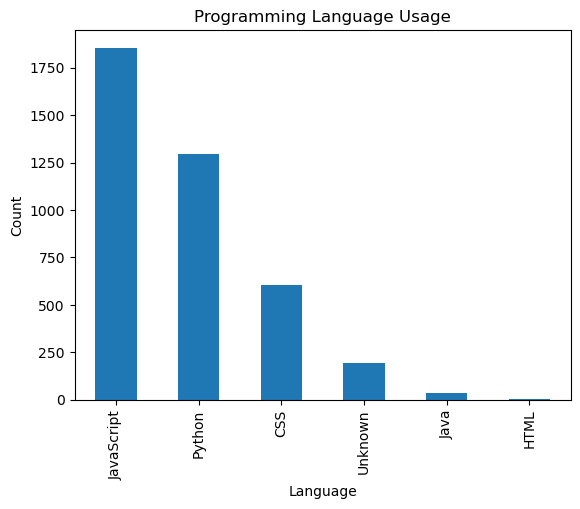

In [7]:
# Convert language counts to DataFrame
language_df = pd.DataFrame(language_counts.items(), columns=['Language', 'Count'])

# Plot bar chart
language_df.sort_values('Count', ascending=False).plot(
    kind='bar', x='Language', y='Count', legend=False, title='Programming Language Usage'
)
plt.ylabel('Count')
plt.show()

## Detecting Most Common Issue Types


In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
fill_mask = pipeline("fill-mask", model="bert-base-uncased", framework="pt")
categories = {
    'Bug': ['bug', 'error', 'issue', 'fix'],
    'Feature Request': ['feature', 'request', 'implement', 'add'],
    'Theoretical Question': ['theoretical', 'concept', 'explain', 'understand'],
    'Optimization': ['optimize', 'performance', 'improve', 'efficient']
}

def expand_keywords_huggingface(keyword_list, top_n=3):
    expanded_keywords = set(keyword_list)
    for keyword in keyword_list:
        results = fill_mask(f"The {keyword} is very [MASK].")
        for result in results[:top_n]:
            expanded_keywords.add(result['token_str'])
    return list(expanded_keywords)

expanded_categories = {
    category: expand_keywords_huggingface(keywords)
    for category, keywords in categories.items()
}
df_expanded_categories = pd.DataFrame.from_dict(expanded_categories, orient='index').transpose()

csv_file_path = "expanded_categories.csv"
df_expanded_categories.to_csv(csv_file_path, index=False)

print(f"Expanded categories saved to {csv_file_path}")
for category, keywords in expanded_categories.items():
    print(f"{category}: {keywords}")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

Expanded categories saved to expanded_categories.csv
Bug: ['bug', 'high', 'important', 'sensitive', 'large', 'serious', 'common', 'variable', 'difficult', 'rare', 'complicated', 'fix', 'issue', 'small', 'simple', 'error']
Feature Request: ['add', 'distinctive', 'request', 'fast', 'efficient', 'feature', 'unusual', 'clear', 'short', 'rare', 'specific', 'implement', 'simple']
Theoretical Question: ['explain', 'concept', 'detailed', 'understand', 'clear', 'complicated', 'basic', 'theoretical', 'complex', 'good', 'simple']
Optimization: ['fast', 'performance', 'optimize', 'improve', 'efficient', 'impressive', 'excellent', 'small', 'good', 'simple']


In [10]:
keyword_to_category = {keyword: category for category, keywords in expanded_categories.items() for keyword in keywords}

if 'Conversations' in df.columns:
    # Replace NaN with empty strings and ensure all values are strings
    text_column = df['Conversations'].fillna("").astype(str)
else:
    raise ValueError("CSV does not contain a 'Conversations' column.")

chunk_size = 1000 
counter = 0       
categories_detected = [] 

# Process the text in chunks
for i in range(0, len(text_column), chunk_size):
    # Select the current chunk
    chunk = text_column[i:i + chunk_size]
    
    # Use multi-threading with nlp.pipe
    docs = list(nlp.pipe(chunk, n_process=-1, batch_size=100))
    
    for doc in docs:
        # Cleaned tokens: lowercase, no stopwords, no spaces, only alphabetic tokens
        cleaned_tokens = [
            t.lower_ for t in doc
            if not t.is_stop and not t.is_space and t.is_alpha
        ]
        
        matched_categories = {keyword_to_category[token] for token in cleaned_tokens if token in keyword_to_category}
        
        categories_detected.append(", ".join(matched_categories) if matched_categories else "Other")
        
        # Increment the counter
        counter += 1
        
        # Print progress every 100 iterations
        if counter % 100 == 0:
            print(f"Processed {counter} texts. Latest categories: {categories_detected[-1]}")

df['DetectedCategories'] = categories_detected
print(f"Completed processing {counter} texts!")

Processed 100 texts. Latest categories: Bug, Theoretical Question, Feature Request
Processed 200 texts. Latest categories: Bug, Feature Request, Optimization
Processed 300 texts. Latest categories: Bug, Theoretical Question, Feature Request, Optimization
Processed 400 texts. Latest categories: Bug, Theoretical Question, Feature Request, Optimization
Processed 500 texts. Latest categories: Bug, Feature Request
Processed 600 texts. Latest categories: Other
Processed 700 texts. Latest categories: Bug, Feature Request
Processed 800 texts. Latest categories: Bug
Processed 900 texts. Latest categories: Bug, Theoretical Question, Feature Request, Optimization
Processed 1000 texts. Latest categories: Bug, Theoretical Question, Feature Request
Processed 1100 texts. Latest categories: Other
Processed 1200 texts. Latest categories: Bug, Theoretical Question, Feature Request
Processed 1300 texts. Latest categories: Bug
Processed 1400 texts. Latest categories: Bug, Feature Request
Processed 1500 te

DetectedCategories
Other                                                       517
Bug, Theoretical Question, Feature Request, Optimization    409
Feature Request                                             204
Bug, Feature Request                                        190
Bug, Theoretical Question, Feature Request                  173
Bug                                                         141
Bug, Feature Request, Optimization                          132
Optimization                                                 48
Bug, Theoretical Question                                    47
Theoretical Question, Feature Request                        45
Bug, Theoretical Question, Optimization                      44
Theoretical Question                                         43
Feature Request, Optimization                                43
Theoretical Question, Feature Request, Optimization          30
Bug, Optimization                                            23
Name: count, dtype: i

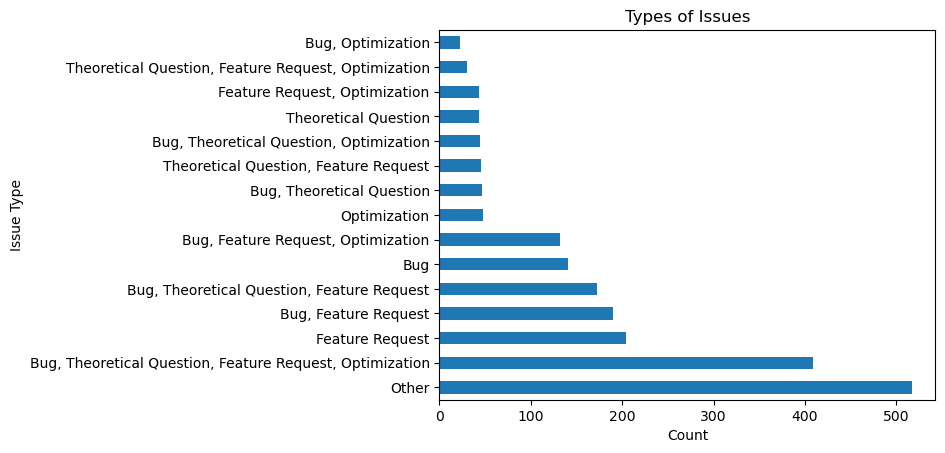

In [11]:
issue_counts = df['DetectedCategories'].value_counts()
print(issue_counts)

issue_counts.plot(kind='barh', title='Types of Issues')
plt.ylabel('Issue Type')
plt.xlabel('Count')
plt.show()